# Analyze A/B Test Results 

This project will assure you have mastered the subjects covered in the statistics lessons. We have organized the current notebook into the following sections: 

- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Final Check](#finalcheck)
- [Submission](#submission)

Specific programming tasks are marked with a **ToDo** tag. 

<a id='intro'></a>
## Introduction

A/B tests are very commonly performed by data analysts and data scientists. For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should:
- Implement the new webpage, 
- Keep the old webpage, or 
- Perhaps run the experiment longer to make their decision.

Each **ToDo** task below has an associated quiz present in the classroom.  Though the classroom quizzes are **not necessary** to complete the project, they help ensure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the [rubric](https://review.udacity.com/#!/rubrics/1214/view) specification. 

>**Tip**: Though it's not a mandate, students can attempt the classroom quizzes to ensure statistical numeric values are calculated correctly in many cases.

<a id='probability'></a>
## Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import scipy
from scipy import stats
import seaborn as sns
%matplotlib inline


#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

### ToDo 1.1
Now, read in the `ab_data.csv` data. Store it in `df`. Below is the description of the data, there are a total of 5 columns:

<center>

|Data columns|Purpose|Valid values|
| ------------- |:-------------| -----:|
|user_id|Unique ID|Int64 values|
|timestamp|Time stamp when the user visited the webpage|-|
|group|In the current A/B experiment, the users are categorized into two broad groups. <br>The `control` group users are expected to be served with `old_page`; and `treatment` group users are matched with the `new_page`. <br>However, **some inaccurate rows** are present in the initial data, such as a `control` group user is matched with a `new_page`. |`['control', 'treatment']`|
|landing_page|It denotes whether the user visited the old or new webpage.|`['old_page', 'new_page']`|
|converted|It denotes whether the user decided to pay for the company's product. Here, `1` means yes, the user bought the product.|`[0, 1]`|
</center>
Use your dataframe to answer the questions in Quiz 1 of the classroom.


>**Tip**: Please save your work regularly.

**a.** Read in the dataset from the `ab_data.csv` file and take a look at the top few rows here:

In [88]:
df = pd.read_csv("ab_data.csv")
df.head(10)

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1
5,936923,2017-01-10 15:20:49.083499,control,old_page,0
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1
7,719014,2017-01-17 01:48:29.539573,control,old_page,0
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1


**b.** Use the cell below to find the number of rows in the dataset.

In [89]:
# 294478 rows
df.shape

(294478, 5)

**c.** The number of unique users in the dataset.

In [90]:
# 290584 users
df.user_id.nunique()

290584

**d.** The proportion of users converted.

In [91]:
# 12%
df['converted'].sum() / len(df)

0.11965919355605512

**e.** The number of times when the "group" is `treatment` but "landing_page" is not a `new_page`.

In [92]:
# 1928 + 1965 = 3893
df.groupby(['group' , 'landing_page'])['landing_page'].count()

group      landing_page
control    new_page          1928
           old_page        145274
treatment  new_page        145311
           old_page          1965
Name: landing_page, dtype: int64

**f.** Do any of the rows have missing values?

In [93]:
#no
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


### ToDo 1.2  
In a particular row, the **group** and **landing_page** columns should have either of the following acceptable values:

|user_id| timestamp|group|landing_page|converted|
|---|---|---|---|---|
|XXXX|XXXX|`control`| `old_page`|X |
|XXXX|XXXX|`treatment`|`new_page`|X |


It means, the `control` group users should match with `old_page`; and `treatment` group users should matched with the `new_page`. 

However, for the rows where `treatment` does not match with `new_page` or `control` does not match with `old_page`, we cannot be sure if such rows truly received the new or old wepage.  


Use **Quiz 2** in the classroom to figure out how should we handle the rows where the group and landing_page columns don't match?

**a.** Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [94]:
df2 = df.drop(df[((df['landing_page'] == 'old_page') & (df['group'] == 'treatment')) | ((df['landing_page'] == 'new_page') & (df['group'] == 'control'))].index)
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [95]:
# Now we copying the dataframe
df2 = df.copy()
df2 = df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) != False]

In [96]:
# dataframe where where treatment is not aligned with new_page or control is not aligned with old_page 
df2 = df[((df['group']=='treatment') & (df['landing_page']=='new_page')) | ((df['group']=='control') & (df['landing_page']=='old_page'))]

In [97]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

### ToDo 1.3  
Use **df2** and the cells below to answer questions for **Quiz 3** in the classroom.

**a.** How many unique **user_id**s are in **df2**?

In [98]:
# Fine the unique user_ids 
df2.user_id.nunique()

290584

**b.** There is one **user_id** repeated in **df2**.  What is it?

In [99]:
# There is user_id repeated in df2
df2.user_id[df2.user_id.duplicated()]

2893    773192
Name: user_id, dtype: int64

In [100]:
duplicated = df2[df2['user_id'].duplicated()]

**c.** Display the rows for the duplicate **user_id**? 

In [101]:
print(duplicated)

      user_id                   timestamp      group landing_page  converted
2893   773192  2017-01-14 02:55:59.590927  treatment     new_page          0


**d.** Remove **one** of the rows with a duplicate **user_id**, from the **df2** dataframe.

In [102]:
# Now we remove duplicate rows
df2 = df2.drop_duplicates(subset='user_id', keep='first')

In [103]:
# Check agin if duplicated values are deleted or not
df2[df2['user_id'].duplicated()].count()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

### ToDo 1.4  
Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

**a.** What is the probability of an individual converting regardless of the page they receive?<br><br>

>**Tip**: The probability  you'll compute represents the overall "converted" success rate in the population and you may call it $p_{population}$.



In [104]:
# 0.1196
df2['converted'].sum() / len(df2)

0.11959708724499628

**b.** Given that an individual was in the `control` group, what is the probability they converted?

In [105]:
# 0.1204
control_conversion = df2[df2['group'] == 'control']['converted'].sum() / len(df2[df2['group'] == 'control'])
control_conversion

0.1203863045004612

**c.** Given that an individual was in the `treatment` group, what is the probability they converted?

In [106]:
# 0.1188
treatment_conversion = df2[df2['group'] == 'treatment']['converted'].sum() / len(df2[df2['group'] == 'treatment'])
treatment_conversion

0.11880806551510564

>**Tip**: The probabilities you've computed in the points (b). and (c). above can also be treated as conversion rate. 
Calculate the actual difference  (`obs_diff`) between the conversion rates for the two groups. You will need that later.  

In [107]:
# Calculate the actual difference (obs_diff) between the conversion rates for the two groups.
obs_diff = treatment_conversion - control_conversion
obs_diff

-0.0015782389853555567

**d.** What is the probability that an individual received the new page?

In [108]:
# 0.5001
df2[df2['landing_page'] == 'new_page']['group'].count() / len(df2)

0.50006194422266881

**e.** Consider your results from parts (a) through (d) above, and explain below whether the new `treatment` group users lead to more conversions.

>**Your answer goes here.** 
The Control Group tends to converte higher that the treatment group

<a id='ab_test'></a>
## Part II - A/B Test

Since a timestamp is associated with each event, you could run a hypothesis test continuously as long as you observe the events. 

However, then the hard questions would be: 
- Do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  
- How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


### ToDo 2.1
For now, consider you need to make the decision just based on all the data provided.  

> Recall that you just calculated that the "converted" probability (or rate) for the old page is *slightly* higher than that of the new page (ToDo 1.4.c). 

If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should be your null and alternative hypotheses (**$H_0$** and **$H_1$**)?  

You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the "converted" probability (or rate) for the old and new pages respectively.

>**Put your answer here.**
H0 : P_old > P_new
H1 : P_old < P_new

### ToDo 2.2 - Null Hypothesis $H_0$ Testing
Under the null hypothesis $H_0$, assume that $p_{new}$ and $p_{old}$ are equal. Furthermore, assume that $p_{new}$ and $p_{old}$ both are equal to the **converted** success rate in the `df2` data regardless of the page. So, our assumption is: <br><br>
<center>
$p_{new}$ = $p_{old}$ = $p_{population}$
</center>

In this section, you will: 

- Simulate (bootstrap) sample data set for both groups, and compute the  "converted" probability $p$ for those samples. 


- Use a sample size for each group equal to the ones in the `df2` data.


- Compute the difference in the "converted" probability for the two samples above. 


- Perform the sampling distribution for the "difference in the converted probability" between the two simulated-samples over 10,000 iterations; and calculate an estimate. 



Use the cells below to provide the necessary parts of this simulation.  You can use **Quiz 5** in the classroom to make sure you are on the right track.

**a.** What is the **conversion rate** for $p_{new}$ under the null hypothesis? 

In [109]:
#the Null hypothesis states there is not difference between the 
#conversion rates of old and new page. Thus, the whole dataset is used to 
#calculate the convertion rate for the new page (pnew).
p_new = df2['converted'].mean()
p_new

0.11959708724499628

**b.** What is the **conversion rate** for $p_{old}$ under the null hypothesis? 

In [110]:
#the Null hypothesis states there is not difference between the 
#conversion rates of old and new page. Thus, the whole dataset is used to 
#calculate the convertion rate for the old_page (pold).
p_old = df2['converted'].mean()
p_old

0.11959708724499628

**c.** What is $n_{new}$, the number of individuals in the treatment group? <br><br>
*Hint*: The treatment group users are shown the new page.

In [111]:
#calculate the number of users landed and new_page
n_new = len(df2.query('landing_page == "new_page"'))
n_new

145310

**d.** What is $n_{old}$, the number of individuals in the control group?

In [112]:
#calculate the number of users landed and new_page
n_old = len(df2.query('landing_page != "new_page"'))
n_old

145274

**e. Simulate Sample for the `treatment` Group**<br> 
Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null hypothesis.  <br><br>
*Hint*: Use `numpy.random.choice()` method to randomly generate $n_{new}$ number of values. <br>
Store these $n_{new}$ 1's and 0's in the `new_page_converted` numpy array.


In [113]:
new_page_converted = np.random.binomial(1,p_new,n_new)

#new_page_converted = np.random.choice([1, 0], size=n_new, p=[p_new, (1-p_new)])
new_page_converted.mean()

0.11834010047484687

**f. Simulate Sample for the `control` Group** <br>
Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null hypothesis. <br> Store these $n_{old}$ 1's and 0's in the `old_page_converted` numpy array.

In [114]:
# Simulate a Sample for the control Group
old_page_converted = np.random.binomial(1,p_old,n_old)

#old_page_converted = np.random.choice([1, 0], size=n_old, p=[p_old, (1-p_old)])
old_page_converted.mean()

0.11996640830430773

**g.** Find the difference in the "converted" probability $(p{'}_{new}$ - $p{'}_{old})$ for your simulated samples from the parts (e) and (f) above. 

In [29]:
#since new_page_converted and old_page_converted have different sizes, 
#I use the mean to get the difference
new_page_converted.mean() - old_page_converted.mean()

0.0012162531450717329


**h. Sampling distribution** <br>
Re-create `new_page_converted` and `old_page_converted` and find the $(p{'}_{new}$ - $p{'}_{old})$ value 10,000 times using the same simulation process you used in parts (a) through (g) above. 

<br>
Store all  $(p{'}_{new}$ - $p{'}_{old})$  values in a NumPy array called `p_diffs`.

In [115]:
# run simulation 10000 times
p_diffs = []
for _ in range(10000):
    old_page_converted = np.random.binomial(1, p_old, n_old)
    csm_b = old_page_converted.mean()
    new_page_converted = np.random.binomial(1, p_new, n_new)
    tsm_b = new_page_converted.mean()
    p_diffs.append(tsm_b - csm_b)

In [31]:
# The numpy way to simulate the above. Does not require a for loop. It also yields the wrong answer (sigh).
# new_converted_simulation = np.random.binomial(n_new, p_new, 10000)/n_new
# old_converted_simulation = np.random.binomial(n_old, p_old, 10000)/n_old
# p_diffs = new_converted_simulation - old_converted_simulation

In [118]:
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


p_diffs = []

for _ in range(10000):
    new_page_converted = np.random.choice([1, 0], size=n_new, p=[p_new, (1-p_new)]).mean()
    old_page_converted = np.random.choice([1, 0], size=n_old, p=[p_old, (1-p_old)]).mean()
    diff = new_page_converted - old_page_converted 
    p_diffs.append(diff)

In [119]:
p_diffs = np.array(p_diffs)
pdm = p_diffs.mean()
pdm

1.6437112150998749e-05

In [120]:
p_diffs.std()

0.0012095968397184574

**i. Histogram**<br> 
Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.<br><br>

Also, use `plt.axvline()` method to mark the actual difference observed  in the `df2` data (recall `obs_diff`), in the chart.  

>**Tip**: Display title, x-label, and y-label in the chart.

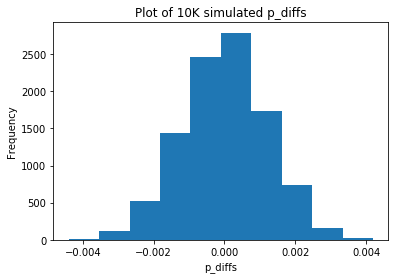

In [35]:
plt.hist(p_diffs)
plt.xlabel('p_diffs')
plt.ylabel('Frequency')
plt.title('Plot of 10K simulated p_diffs');

**j.** What proportion of the **p_diffs** are greater than the actual difference observed in the `df2` data?

In [36]:
# compute difference from original dataset ab_data.csv
act_diff = df[df['group'] == 'treatment']['converted'].mean() -  df[df['group'] == 'control']['converted'].mean()
act_diff

-0.0014795997940775518

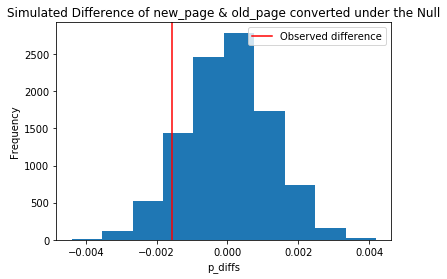

In [37]:
# plot line for observed statistic
plt.hist(p_diffs)
plt.axvline(x=obs_diff, color='r', label="Observed difference")
plt.xlabel('p_diffs')
plt.ylabel('Frequency')
plt.title('Simulated Difference of new_page & old_page converted under the Null');
plt.legend()
plt.show()

In [38]:
p_diffs = np.array(p_diffs)
p_diffs

array([ 0.00229693, -0.00054599, -0.00128916, ...,  0.00126434,
       -0.00020857, -0.00069031])

In [39]:
# proportion of p_diffs greater than the actual difference observed in ab_data.csv is computed as:
(p_diffs > obs_diff).mean()

0.9032

**k.** Please explain in words what you have just computed in part **j** above.  
 - What is this value called in scientific studies?  
 - What does this value signify in terms of whether or not there is a difference between the new and old pages? *Hint*: Compare the value above with the "Type I error rate (0.05)".
  What was computed in part j was the p-value, which is the measurement of the probability of observing a statistic, in this case the conversion rate, or one more extreme in favor of the alternative, if the null hypothesis is true. Since the p-value is higher than the Type I error rate of 5%, we fail to reject the null hypothesis, and that the treatment page does not have higher conversion rates than the control page on a statistically significant basis.



**l. Using Built-in Methods for Hypothesis Testing**<br>
We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. 

Fill in the statements below to calculate the:
- `convert_old`: number of conversions with the old_page
- `convert_new`: number of conversions with the new_page
- `n_old`: number of individuals who were shown the old_page
- `n_new`: number of individuals who were shown the new_page


In [40]:
convert_old = df2.query('group == "control" & converted == 1')['converted'].count()
convert_new = df2.query('group == "treatment" & converted == 1')['converted'].count()
convert_old, convert_new, n_old, n_new

(17489, 17264, 145274, 145310)

# **m.** Now use `sm.stats.proportions_ztest()` to compute your test statistic and p-value.  [Here](https://www.statsmodels.org/stable/generated/statsmodels.stats.proportion.proportions_ztest.html) is a helpful link on using the built in.

The syntax is: 
```bash
proportions_ztest(count_array, nobs_array, alternative='larger')
```
where, 
- `count_array` = represents the number of "converted" for each group
- `nobs_array` = represents the total number of observations (rows) in each group
- `alternative` = choose one of the values from `[‘two-sided’, ‘smaller’, ‘larger’]` depending upon two-tailed, left-tailed, or right-tailed respectively. 
>**Hint**: <br>
It's a two-tailed if you defined $H_1$ as $(p_{new} = p_{old})$. <br>
It's a left-tailed if you defined $H_1$ as $(p_{new} < p_{old})$. <br>
It's a right-tailed if you defined $H_1$ as $(p_{new} > p_{old})$. 

The built-in function above will return the z_score, p_value. 

---
### About the two-sample z-test
Recall that you have plotted a distribution `p_diffs` representing the
difference in the "converted" probability  $(p{'}_{new}-p{'}_{old})$  for your two simulated samples 10,000 times. 

Another way for comparing the mean of two independent and normal distribution is a **two-sample z-test**. You can perform the Z-test to calculate the Z_score, as shown in the equation below:

$$
Z_{score} = \frac{ (p{'}_{new}-p{'}_{old}) - (p_{new}  -  p_{old})}{ \sqrt{ \frac{\sigma^{2}_{new} }{n_{new}} + \frac{\sigma^{2}_{old} }{n_{old}}  } }
$$

where,
- $p{'}$ is the "converted" success rate in the sample
- $p_{new}$ and $p_{old}$ are the "converted" success rate for the two groups in the population. 
- $\sigma_{new}$ and $\sigma_{new}$ are the standard deviation for the two groups in the population. 
- $n_{new}$ and $n_{old}$ represent the size of the two groups or samples (it's same in our case)


>Z-test is performed when the sample size is large, and the population variance is known. The z-score represents the distance between the two "converted" success rates in terms of the standard error. 

Next step is to make a decision to reject or fail to reject the null hypothesis based on comparing these two values: 
- $Z_{score}$
- $Z_{\alpha}$ or $Z_{0.05}$, also known as critical value at 95% confidence interval.  $Z_{0.05}$ is 1.645 for one-tailed tests,  and 1.960 for two-tailed test. You can determine the $Z_{\alpha}$ from the z-table manually. 

Decide if your hypothesis is either a two-tailed, left-tailed, or right-tailed test. Accordingly, reject OR fail to reject the  null based on the comparison between $Z_{score}$ and $Z_{\alpha}$. 
>Hint:<br>
For a right-tailed test, reject null if $Z_{score}$ > $Z_{\alpha}$. <br>
For a left-tailed test, reject null if $Z_{score}$ < $Z_{\alpha}$. 


In other words, we determine whether or not the $Z_{score}$ lies in the "rejection region" in the distribution. A "rejection region" is an interval where the null hypothesis is rejected iff the $Z_{score}$ lies in that region.



Reference: 
- Example 9.1.2 on this [page](https://stats.libretexts.org/Bookshelves/Introductory_Statistics/Book%3A_Introductory_Statistics_(Shafer_and_Zhang)/09%3A_Two-Sample_Problems/9.01%3A_Comparison_of_Two_Population_Means-_Large_Independent_Samples), courtesy www.stats.libretexts.org

---

>**Tip**: You don't have to dive deeper into z-test for this exercise. **Try having an overview of what does z-score signify in general.** 

In [122]:
import statsmodels.api as sm

n_new = len(df2.query('landing_page == "new_page"'))
n_old = len(df2.query('landing_page == "old_page"'))
convert_new = len(df2.query('landing_page == "new_page" & converted == 1'))
convert_old = len(df2.query('landing_page == "old_page" & converted == 1'))

In [123]:
z_score, p_value = sm.stats.proportions_ztest(np.array([convert_new, convert_old]),np.array([n_new, n_old]), alternative = 'larger')
z_score, p_value

(-1.3109241984234394, 0.90505831275902449)

>**Put your answer here.**
The z-score here is -1.31 inside our critical value of 1.959 and the p-value is still large, So it is likely that our statistic is from the null
This means the z-score and p-value agree with the findings in parts j and k that we cannot reject the null hypothesis.

**n.** What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?<br><br>

>**Tip**: Notice whether the p-value is similar to the one computed earlier. Accordingly, can you reject/fail to reject the null hypothesis? It is important to correctly interpret the test statistic and p-value.

In [124]:
from scipy.stats import norm
norm.cdf(z_score) #how significant our z_score is

0.094941687240975514

In [125]:
norm.ppf(1-(0.05)) #critical value of 95% confidence

1.6448536269514722

<a id='regression'></a>
### Part III - A regression approach

### ToDo 3.1 
In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

**a.** Since each row in the `df2` data is either a conversion or no conversion, what type of regression should you be performing in this case?

>**Put your answer here.**
Logistic Regression

**b.** The goal is to use **statsmodels** library to fit the regression model you specified in part **a.** above to see if there is a significant difference in conversion based on the page-type a customer receives. However, you first need to create the following two columns in the `df2` dataframe:
 1. `intercept` - It should be `1` in the entire column. 
 2. `ab_page` - It's a dummy variable column, having a value `1` when an individual receives the **treatment**, otherwise `0`.  

In [126]:
df2['intercept'] = 1
# use one hot encoding for categorical feature
df2['ab_page'] = pd.get_dummies(df2.group)["treatment"]

In [127]:
df2.head(2)

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0


**c.** Use **statsmodels** to instantiate your regression model on the two columns you created in part (b). above, then fit the model to predict whether or not an individual converts. 


In [128]:
import statsmodels.api as sm
logit_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = logit_mod.fit();

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


**d.** Provide the summary of your model below, and use it as necessary to answer the following questions.

In [129]:
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2022-10-25 18:02 AIC:              212780.3502
No. Observations:   290584           BIC:              212801.5095
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

In [130]:
# in logistic regression in order to interpret your coefficients efficiently we have to exponentiate it
expon_coff = np.exp(results.params)
expon_coff

intercept    0.136863
ab_page      0.985123
dtype: float64

In [131]:
# however becuase the coefficinets are now below one it would be more useful if we divide one over these results 
1 / expon_coff

intercept    7.306593
ab_page      1.015102
dtype: float64

**e.** What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  

**Hints**: 
- What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**? 
- You may comment on if these hypothesis (Part II vs. Part III) are one-sided or two-sided. 
- You may also compare the current p-value with the Type I error rate (0.05).


>**Put your answer here.**
the current p_value is too high so we stick with the null hypothesis part 2 is two sided but part 3 is one sided the null hypothesis is the regression model is that there is no effect and the alternative is there is an effect.

**f.** Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

>**Put your answeryes  the disadvantage is that sometimes adding more factors can lead to false conclusions, also adding more factors reqiure more more effort and time which in some cases might be a waste of time. here.**
Beacause we might acually found a group of factor and some of the disadvantages is that multicollinearity when we add additional terms to our model

**g. Adding countries**<br> 
Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. 

1. You will need to read in the **countries.csv** dataset and merge together your `df2` datasets on the appropriate rows. You call the resulting dataframe `df_merged`. [Here](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.join.html) are the docs for joining tables. 

2. Does it appear that country had an impact on conversion?  To answer this question, consider the three unique values, `['UK', 'US', 'CA']`, in the `country` column. Create dummy variables for these country columns. 
>**Hint:** Use `pandas.get_dummies()` to create dummy variables. **You will utilize two columns for the three dummy variables.** 

 Provide the statistical output as well as a written response to answer this question.

In [132]:
## Read the countries.csv
# Store Countries.csv data in dataframe df = pd.read_csv('countries.csv')
df = pd.read_csv("countries.csv")
df_new = df.set_index('user_id').join(df2.set_index('user_id'), how='inner')

In [133]:
df.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [53]:
df_new

,country,timestamp,group,landing_page,converted,intercept,ab_page
user_id,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1
909908,UK,2017-01-06 20:44:26.334764,treatment,new_page,0,1,1
811617,US,2017-01-02 18:42:11.851370,treatment,new_page,1,1,1
938122,US,2017-01-10 09:32:08.222716,treatment,new_page,1,1,1
887018,US,2017-01-06 11:09:40.487196,treatment,new_page,0,1,1


In [134]:
# count the values
df.groupby("country").count()

,user_id
country,
CA,14499
UK,72466
US,203619


In [135]:
# verify if they have the same number of lines
df.count()[0], df.count()[0]

(290584, 290584)

In [136]:
# one hot encoding 

In [137]:
# Create the necessary dummy variables
df_new[['US', 'UK']] = pd.get_dummies(df_new["country"])[["UK","US"]]
df_new.head(2)

,country,timestamp,group,landing_page,converted,intercept,ab_page,US,UK
user_id,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,1


## **h. Fit your model and obtain the results**<br> 
Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if are there significant effects on conversion.  **Create the necessary additional columns, and fit the new model.** 


Provide the summary results (statistical output), and your conclusions (written response) based on the results. 

>**Tip**: Conclusions should include both statistical reasoning, and practical reasoning for the situation. 

>**Hints**: 
- Look at all of p-values in the summary, and compare against the Type I error rate (0.05). 
- Can you reject/fail to reject the null hypotheses (regression model)?
- Comment on the effect of page and country to predict the conversion.


In [138]:
# Create new feature for the new page by country
df_new['US_page'] = df_new['US'] * df_new['ab_page']
df_new['UK_page'] = df_new['UK'] * df_new['ab_page']

In [139]:
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,US,UK,US_page,UK_page
user_id,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,1,0,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,1,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,1,0,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,1,0,1,0


In [140]:
# Fit your model, and summarize the results
log_mod = sm.Logit(df_new['converted'], df_new[['UK', 'US']])
results = log_mod.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.382864
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: -0.046     
Date:               2022-10-25 18:03 AIC:              222512.1606
No. Observations:   290584           BIC:              222533.3199
Df Model:           1                Log-Likelihood:   -1.1125e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
--------------------------------------------------------------------
          Coef.    Std.Err.       z       P>|z|     [0.025    0.975]
--------------------------------------------------------------------
UK       -1.9967     0.0068   -292.3145   0.0000   -2.0101   -1.9833
US       -1.9868     0.0114   -174.1736   0.0000   -2.0092   -1.9645
==================================================================

"""

In [141]:
np.exp(results.params)

UK    0.135779
US    0.137132
dtype: float64

In [142]:
df_new.groupby('group').mean()['converted']

group
control      0.120386
treatment    0.118808
Name: converted, dtype: float64

>**Put your conclusion answer here.**
p_value is higher than 0.05
There is no enough evidence that the new_page increases the conversion rate as compared to the old_page.
There is no evidence that the countries influence the conversion rate.

<a id='finalcheck'></a>
## Final Check!

Congratulations!  You have reached the end of the A/B Test Results project!  You should be very proud of all you have accomplished!

> **Tip**: Once you are satisfied with your work here, check over your notebook to make sure that it satisfies all the specifications mentioned in the rubric. You should also probably remove all of the "Hints" and "Tips" like this one so that the presentation is as polished as possible.


<a id='submission'></a>
## Submission
You may either submit your notebook through the "SUBMIT PROJECT" button at the bottom of this workspace, or you may work from your local machine and submit on  the last page of this project lesson.  

1. Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).


2. Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.


3. Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations!

In [143]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0